In [3]:
import math
import random
import yaml
import argparse
from dotmap import DotMap

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam

# import matplotlib.pyplot as plt
import wandb

import sys
sys.path.append("./src")  # make sure Python can find src/
import data
from model_linear import GPTLinear
from model_softmax import GPTSoftmax
from multi_task_train import train_step


def set_seed(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    ## Not sure if below would work if I dont have gpu
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")


def load_config(config_path: str):
    """Load YAML config and convert to DotMap."""
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)
    cfg = DotMap(cfg)
    return cfg


def prepare_data_samplers(config):
    """Create a dict of data samplers for each task."""
    num_task = len(config.data.tasks)
    data_samplers = {}
    for i in range(num_task):
        task = config.data.tasks[i]
        task_class = getattr(data, task.name)
        data_samplers[task.name] = task_class(
            min_num=config.data.min_num,
            max_num=config.data.max_num,
            k=config.data.k if hasattr(config.data, 'k') else None,
            p=config.data.p if hasattr(config.data, 'p') else None,
            sep=task.sep,
        )
    return data_samplers

In [22]:
import torch
import torch.nn as nn
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import wandb  # only if config.train.wandb = True

# Optional, depending on your setup
import numpy as np

def train_step(
    model,
    optim,
    data_samplers,
    step,
    config,
    device,
):
    n_train, n_test, num_tokens = (
        config.data.n_train,
        config.data.n_test,
        config.data.num_tokens,
    )

    # --- MIXED BATCH SAMPLING ---
    # task_names = list(data_samplers.keys())
    n_tasks = len(data_samplers)

    n_train_each = n_train // n_tasks
    n_test_each = n_test // n_tasks

    mixed_train = {}
    mixed_test = {}

    for name, sampler in data_samplers.items():
        data = sampler.sample(
            num_samples=n_train_each + n_test_each,
            num_tokens=num_tokens,
        )
        train_part = data[:n_train_each, :]
        test_part = data[n_train_each:, :]
        mixed_train[name] = train_part
        mixed_test[name] = test_part

    train_data = torch.cat(list(mixed_train.values()), dim=0)
    test_data = torch.cat(list(mixed_test.values()), dim=0)

    if config.data.mix == 'random':
        # optionally shuffle to fully mix across tasks
        perm = torch.randperm(train_data.size(0))
        train_data = train_data[perm]
        perm = torch.randperm(test_data.size(0))
        test_data = test_data[perm]

    prompt_len = num_tokens + 1
    gen_len = num_tokens
    acc_start = num_tokens + 1

    model.train()
    optim.zero_grad(set_to_none=True)

    _, _, _, loss = model(
        train_data[:, :-1], 
        targets=train_data[:, 1:], 
        prompt_len =prompt_len, 
        mask_input=config.train.mask_input,
    )
    loss.backward()

    if config.train.grad_clip > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.train.grad_clip)

    optim.step()

    model.eval()
    with torch.no_grad():
        ### Per task metrics
        if n_tasks > 1:
            examples_seen_per_task = n_train_each * (step + 1)
            per_task_metrics = {}

            for task_name in mixed_train.keys():
                t_train = mixed_train[task_name]
                t_test = mixed_test[task_name]

                # Compute loss on this task
                _, _, _, task_train_loss = model(
                    t_train[:, :-1],
                    targets=t_train[:, 1:],
                    prompt_len=prompt_len,
                    mask_input=config.train.mask_input,
                )

                # Predictions
                t_train_pred = model.generate(
                    idx=t_train[:, :prompt_len],
                    max_new_tokens=gen_len,
                    prompt_len=prompt_len,
                )
                t_test_pred = model.generate(
                    idx=t_test[:, :prompt_len],
                    max_new_tokens=gen_len,
                    prompt_len=prompt_len,
                )

                # Accuracy for this task
                t_train_acc = torch.mean(
                    (t_train_pred[:, acc_start:] == t_train[:, acc_start:]).float()
                ).item()
                t_test_acc = torch.mean(
                    (t_test_pred[:, acc_start:] == t_test[:, acc_start:]).float()
                ).item()

                # Store
                per_task_metrics[task_name] = {
                    "train_loss": task_train_loss.item(),
                    "train_acc": t_train_acc,
                    "test_acc": t_test_acc,
                    # "num_train_samples": t_train.shape[0],
                    # "num_test_samples": t_test.shape[0],
                }
            
            if config.train.wandb:
                for task_name, vals in per_task_metrics.items():
                    wandb.log({
                        f"{task_name}/train_loss": vals["train_loss"],
                        f"{task_name}/train_acc": vals["train_acc"],
                        f"{task_name}/test_acc": vals["test_acc"],
                        # f"{task_name}/num_train_samples": vals["num_train_samples"],
                        f"{task_name}/examples_seen": examples_seen_per_task,
                    }, step=step)

        # Log train loss, train / test acc, repetition frequency
        attn_map, pre_lm_h, _, train_loss = model(
            train_data[:, :-1], 
            targets=train_data[:, 1:], 
            prompt_len =prompt_len, 
            mask_input=config.train.mask_input,
            )

        train_pred = model.generate(
            idx=train_data[:, :prompt_len],
            max_new_tokens=gen_len,
            prompt_len =prompt_len,
        )
        test_pred = model.generate(
            idx=test_data[:, :prompt_len],
            max_new_tokens=gen_len,
            prompt_len =prompt_len,
        )

        train_acc = torch.mean(
            (train_pred[:, acc_start:] == train_data[:, acc_start:]).to(float)
        ).item()
        test_acc = torch.mean(
            (test_pred[:, acc_start:] == test_data[:, acc_start:]).to(float)
        ).item()

        data_repeat_frac = torch.mean((test_data[:, acc_start:-1] == test_data[:, acc_start+1:]).to(float))
        model_repeat_frac = torch.mean((test_pred[:, acc_start:-1] == test_pred[:, acc_start+1:]).to(float))

        # Log attention progress measure
        attn_map_output_seq = attn_map[:, :, acc_start-1:]
        att_mask = torch.zeros_like(attn_map_output_seq).to(device)

        att_mask[:, :, 0, 0] = 1
        for i in range(num_tokens - 1):
            att_mask[:, :, i + 1, i : i + 2] = 1

        att_prog_measure = torch.mean(
            torch.sum(torch.abs(attn_map_output_seq) * att_mask, dim=(-3, -2, -1)) /
            torch.sum(torch.abs(attn_map_output_seq), dim=(-3, -2, -1)),
            dim=0
        )

        # Log pair-wise cosine similarity between hidden states
        embed_start = acc_start - 1
        embed_len = gen_len

        logit_cs = torch.zeros((embed_len, embed_len))

        for i_1 in range(embed_start, embed_start + embed_len):
            for i_2 in range(embed_start, i_1):
                logit_cs[i_1 - embed_start, i_2 - embed_start] = torch.mean(
                    (
                        cosine_similarity(
                            pre_lm_h[:, i_1, :], pre_lm_h[:, i_2, :], dim=-1
                        )
                    ), dim=0
                )

        # --- Cosine similarity figure ---
        logit_fig, ax_cs = plt.subplots(figsize=(10,10))
        im_cs = ax_cs.imshow(logit_cs)
        ax_cs.set_title("avg pre_lm_h cosine sim")
        logit_fig.colorbar(im_cs, ax=ax_cs, shrink=0.9)
        ax_cs.set_xticks(range(embed_len))
        ax_cs.set_yticks(range(embed_len))
        ax_cs.set_xlabel("Token index")
        ax_cs.set_ylabel("Token index")
        plt.tight_layout()
        # plt.show()

        # Optional: overlay numbers
        for i1 in range(embed_len):
            for i2 in range(embed_len):
                ax_cs.text(i2, i1, f"{logit_cs[i1, i2].item():.2f}",
                        ha="center", va="center", color="w" if logit_cs[i1, i2] < logit_cs.max()/2 else "k")
    

        if config.train.wandb:
            wandb.log({"pre_lm_h_cosine_sim": logit_fig}, step=step)
        plt.close(logit_fig)


        # --- Attention maps per head (averaged over batch) ---
        avg_attn_per_head = attn_map.mean(dim=0).detach().cpu().numpy()  # shape: (n_head, T, T)

        for h in range(config.model.n_head):
            fig_head, ax_head = plt.subplots(figsize=(10,10))
            im_head = ax_head.imshow(avg_attn_per_head[h])
            ax_head.set_title(f"Head {h} avg attention")
            fig_head.colorbar(im_head, ax=ax_head, shrink=0.9)
            ax_head.set_xticks(range(avg_attn_per_head[h].shape[-1]))
            ax_head.set_yticks(range(avg_attn_per_head[h].shape[-2]))
            
            if config.train.wandb:
                wandb.log({f"Head_{h}_avg_attention": fig_head}, step=step)
            plt.close(fig_head)


        print(
            f"Step {step} -- Train loss: {train_loss}, Train Acc: {train_acc} Test Acc: {test_acc}"
        )
        # print(f"input: {test_data[0]} \n predicted:{test_pred[0]}")
        if config.train.wandb:
            
            log_data = {
                'examples_seen_per_task': examples_seen_per_task,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "data_repeat_frac": data_repeat_frac,
                "model_repeat_frac": model_repeat_frac,
                "att_prog_measure": att_prog_measure,
                # "pre_lm_h_cosine_sim": logit_fig,
                "mean_cosine_sim": torch.sum(logit_cs[:, 1:]) / (0.5 * (gen_len-1) * (gen_len-2))
            }

            for output_pos in range(gen_len):
                log_data.update(
                    {
                        f"idx{output_pos}_check": torch.mean(
                            (train_pred[:, acc_start + output_pos] == train_data[:, acc_start + output_pos]).to(float)
                        ).item()
                    }
                )

                if output_pos < gen_len-1:
                    log_data.update(
                        {
                            f"mean_cosine_sim_{output_pos}": torch.sum(logit_cs[:, output_pos]) / (gen_len-1-output_pos)
                        }
                    )

            wandb.log(log_data, step=step)

        plt.close()
        del (
            logit_fig,
            ax_cs,
            logit_cs,
            ax_head,
            fig_head

        )

        if config.train.save_ckpt:
            if (step == 0) or ((step + 1) % config.train.ckpt_freq == 0):
                model.train()
                torch.save(
                    {
                        "epoch": step,
                        "model": model.state_dict(),
                        "optim": optim.state_dict(),
                        "train_loss": train_loss,
                        "test_acc": test_acc,
                    },
                    "./mws_k2_l1_h1_a16_n16.tar",
                )
                print(f"saved state at epoch {step} to {f'./mws_k2_l1_h1_a16_n16.tar'}")

                if config.train.wandb:
                    model_wandb = wandb.Artifact(
                        f"model_step{step}", type="model"
                    )
                    model_wandb.add_file(f"./mws_k2_l1_h1_a16_n16.tar")
                    wandb.log_artifact(model_wandb)
                    print("model uploaded to wandb")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Seed set to 67


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MovingWindowProduct/examples_seen,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
MovingWindowProduct/test_acc,▅▅▂▄▁▃█▂▃▅▄▄▅▅▅▅▆▆▇▃▇
MovingWindowProduct/train_acc,▄█▃▄▅▆▁▅▃▃▄▁▅▇▅█▇▇▇▆▅
MovingWindowProduct/train_loss,██▆▅▄▃▄▃▃▂▂▂▂▁▂▂▁▁▂▁▁
MovingWindowSum/examples_seen,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
MovingWindowSum/test_acc,▂▂▅▁▆▃▃▆▅▄▂▃▄▄▆▂▇▄▅▂█
MovingWindowSum/train_acc,▂▄▁▃▁▃▃▂▃▁▄▃▁▄▅▄█▅▇▆█
MovingWindowSum/train_loss,█▇▆▇▇▅▄▆▆▆▄▆▄▄▃▂▄▁▂▁▁
att_prog_measure,▁▂▂▁▂▃▃▃▄▅▄▅▅▅▇▇▇███
data_repeat_frac,▁▅▁▄▇▂▅▄▅█▄▄▃▄▆▇▆█▆▇
examples_seen_per_task,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


Step 0 -- Train loss: 2.880411148071289, Train Acc: 0.063720703125 Test Acc: 0.060546875
Step 1 -- Train loss: 2.876390218734741, Train Acc: 0.07373046875 Test Acc: 0.060546875
Step 2 -- Train loss: 2.864926338195801, Train Acc: 0.058837890625 Test Acc: 0.0654296875
Step 3 -- Train loss: 2.859476327896118, Train Acc: 0.06494140625 Test Acc: 0.0556640625
Step 4 -- Train loss: 2.8546979427337646, Train Acc: 0.064453125 Test Acc: 0.064453125
Step 5 -- Train loss: 2.8414862155914307, Train Acc: 0.0693359375 Test Acc: 0.0595703125
Step 6 -- Train loss: 2.842879056930542, Train Acc: 0.061279296875 Test Acc: 0.07421875
Step 7 -- Train loss: 2.841280460357666, Train Acc: 0.065185546875 Test Acc: 0.0673828125
Step 8 -- Train loss: 2.8434133529663086, Train Acc: 0.064208984375 Test Acc: 0.0703125
Step 9 -- Train loss: 2.8364195823669434, Train Acc: 0.060302734375 Test Acc: 0.068359375
Step 10 -- Train loss: 2.8284096717834473, Train Acc: 0.067138671875 Test Acc: 0.05859375
Step 11 -- Train loss:

KeyboardInterrupt: 

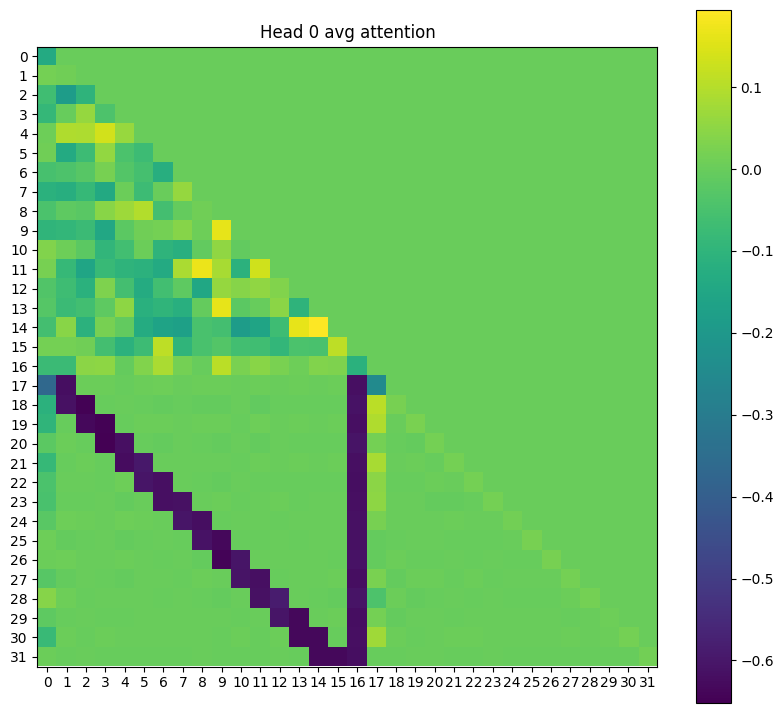

In [23]:
config = load_config('src/configs/mix1_mws_mwp_2head.yaml')

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seeds
seed = getattr(config.train, "seed", 42)
set_seed(seed)

# Model settings -- May needs tweaking
config.model.vocab_size = max(getattr(config.data, "p", 16), config.data.max_num) + 1
config.model.block_size = 2 * config.data.num_tokens + 1

# Prepare data samplers
data_samplers = prepare_data_samplers(config)

# Initialize model
if config.model.linear:
    model = GPTLinear(config.model, return_att=True).to(device)
else:
    model = GPTSoftmax(config.model, return_att=True).to(device)

if config.train.freeze_embedding:
    for param in model.transformer.wte.parameters():
        param.requires_grad = False
    for param in model.transformer.wpe.parameters():
        param.requires_grad = False
# Optimizer
optim = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.train.lr)

# WandB setup
if getattr(config.train, "wandb", False):
    wandb_run_name = getattr(config.train, "wandb_run_name", None)
    wandb.login(key="")
    wandb.init(project=config.train.wandb_project, name=wandb_run_name, config=config)
    wandb.watch(model)

# Training loop
for step in range(config.train.num_steps):
    train_step(
        model=model,
        optim=optim,
        data_samplers=data_samplers,
        step=step,
        config=config,
        device=device,
    )

if getattr(config.train, "wandb", False):
    wandb.finish()

In [20]:
len(data_samplers)

2

In [12]:
n_train, n_test, num_tokens = (
    config.data.n_train,
    config.data.n_test,
    config.data.num_tokens,
)

task_names = list(data_samplers.keys())
n_tasks = len(task_names)

n_train_each = n_train // n_tasks
n_test_each = n_test // n_tasks

In [17]:
mixed_train = {}
mixed_test = {}

for name, sampler in data_samplers.items():
    data = sampler.sample(
        num_samples=n_train_each + n_test_each,
        num_tokens=num_tokens,
    )
    train_part = data[:n_train_each, :]
    test_part = data[n_train_each:, :]
    mixed_train[name] = train_part
    mixed_test[name] = test_part

train_data = torch.cat(list(mixed_train.values()), dim=0)
test_data = torch.cat(list(mixed_test.values()), dim=0)